# Exploratory Data Analysis of RHoMIS Data

Exploring the RHoMIS data set, and other data sources it could potentially be merged with. Assessing coverage and potential for a farm-size mapping.

## Setup

In [8]:
# Setup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from farmsize import data_prep, db_scan, mapping
from shapely.geometry import Point
import math
import seaborn as sns

In [9]:
# Reading in Data Sources
country_mapping = data_prep.load_json("./data/country_mappings.json")

ipums_terra = mapping.read_geo_csv("./data/ipums/processed/ipums_terra_merged.csv")
ipums_terra = ipums_terra.loc[ipums_terra["iso_2"].isin(country_mapping["iso_2"]),:]
ipums_terra = ipums_terra.merge(country_mapping, left_on="iso_2", right_on="iso_2", how="left")

# Loading RHoMIS Indicators
indicator_data = pd.read_csv("./data/RHoMIS_Indicators.csv", encoding="latin")
countries_iso_2 = country_mapping["iso_2"].to_list()
indicator_data = data_prep.subset_data(indicator_data, complete_gps=True, countries=countries_iso_2) # Subsetting data bas

# World Shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

/home/lgorman/research/PhD/farm_size_analysis_python/farm_size_analysis_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (71) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
# Spatially joining the household survey, the world shapefile, and the ipums terra data
indicator_data["geometry"] = [Point(xy) for xy in zip(indicator_data["GPS_LON"], indicator_data["GPS_LAT"])]
geo_indicator = gpd.GeoDataFrame(indicator_data)
geo_indicator = geo_indicator.sjoin(world, how="left", op="within")
geo_indicator = geo_indicator.rename(columns={"index_right":"index_world_shapefile"})
geo_indicator = geo_indicator.sjoin(ipums_terra, how="left", op="within")
geo_indicator = geo_indicator.rename(columns={"index_right":"index_ipums_terra"})



/home/lgorman/research/PhD/farm_size_analysis_python/farm_size_analysis_env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/lgorman/research/PhD/farm_size_analysis_python/farm_size_analysis_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3251: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/lgorman/research/PhD/farm_size_analysis_python/farm_size_analysis_env/lib/python3.8/site-packages/geopandas/geodataframe.py:1938: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: N

In [11]:
burkina_lsms = data_prep.link_points_to_ipums_and_world("BFA","latitude","longitude","./data/lsms/LSMS_Burkina_landsizes.csv",ipums_terra,world)
ethiopia_lsms = data_prep.link_points_to_ipums_and_world("ETH","latitude","longitude","./data/lsms/LSMS_Ethiopia_landsizes.csv",ipums_terra,world)
malawi_lsms = data_prep.link_points_to_ipums_and_world("MWI","Latitude","Longitude","./data/lsms/LSMS_Malawi_2011_landsizes.csv",ipums_terra,world)
malawi_lsms.rename({"Latitude":"latitude", "Longitude":"longitude"}, inplace=True)
niger_lsms = data_prep.link_points_to_ipums_and_world("NER","latitude","longitude","./data/lsms/LSMS_Niger_landsizes.csv",ipums_terra,world)
nigeria_lsms = data_prep.link_points_to_ipums_and_world("NGA","Latitude","Longitude","./data/lsms/LSMS_Nigeria_landsizes.csv",ipums_terra,world)
nigeria_lsms.rename({"Latitude":"latitude", "Longitude":"longitude"}, inplace=True)

tanzania_lsms = data_prep.link_points_to_ipums_and_world("TZA","latitude","longitude","./data/lsms/LSMS_Tanzania_landsizes.csv",ipums_terra,world)
uganda_lsms = data_prep.link_points_to_ipums_and_world("UGA","Latitude","Longitude","./data/lsms/LSMS_Uganda_2012_landsizes.csv",ipums_terra,world)
uganda_lsms.rename({"Latitude":"latitude", "Longitude":"longitude"}, inplace=True)


lsms_data = pd.concat([burkina_lsms,ethiopia_lsms, malawi_lsms, niger_lsms, nigeria_lsms, tanzania_lsms, uganda_lsms])
lsms_data.to_csv("./data/lsms/lsms_all.csv",index=False)

/home/lgorman/research/PhD/farm_size_analysis_python/farm_size_analysis_env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/lgorman/research/PhD/farm_size_analysis_python/farm_size_analysis_env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/lgorman/research/PhD/farm_size_analysis_python/farm_size_analysis_env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array

In [12]:
lsms_data = mapping.read_geo_csv("./data/lsms/lsms_all.csv")


/tmp/ipykernel_12634/2248269114.py:1: DtypeWarning: Columns (1,2,7,9,10,116,118,119,120,126,128,281,289,291) have mixed types.Specify dtype option on import or set low_memory=False.
  lsms_data = mapping.read_geo_csv("./data/lsms/lsms_all.csv")


## Assessing Data Coverage

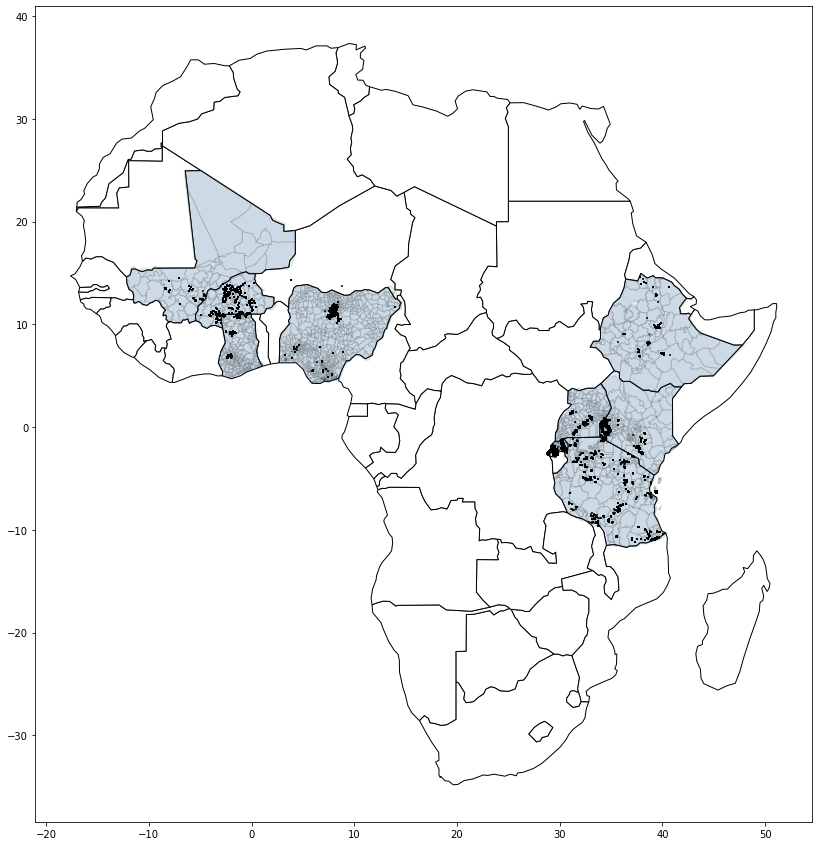

In [13]:
fig, ax =  plt.subplots(figsize=(15,15))
ax.set_aspect('equal')
#Plot map layer
world.loc[world["continent"]=="Africa",].plot(ax=ax,color="white", edgecolor="black")

world.loc[world["iso_a3"].isin(country_mapping["iso_3"]),].plot(ax=ax,color="blue", edgecolor="black", alpha=0.1)
ipums_terra .plot(ax=ax, color="green", edgecolor="black", alpha=0.1)
#Plot Points
geo_indicator.plot(ax=ax, marker=0, color='black', markersize=5)

fig.show()
fig.savefig('./outputs/exploratory/map.png')


## Assessing Land Size Distributions

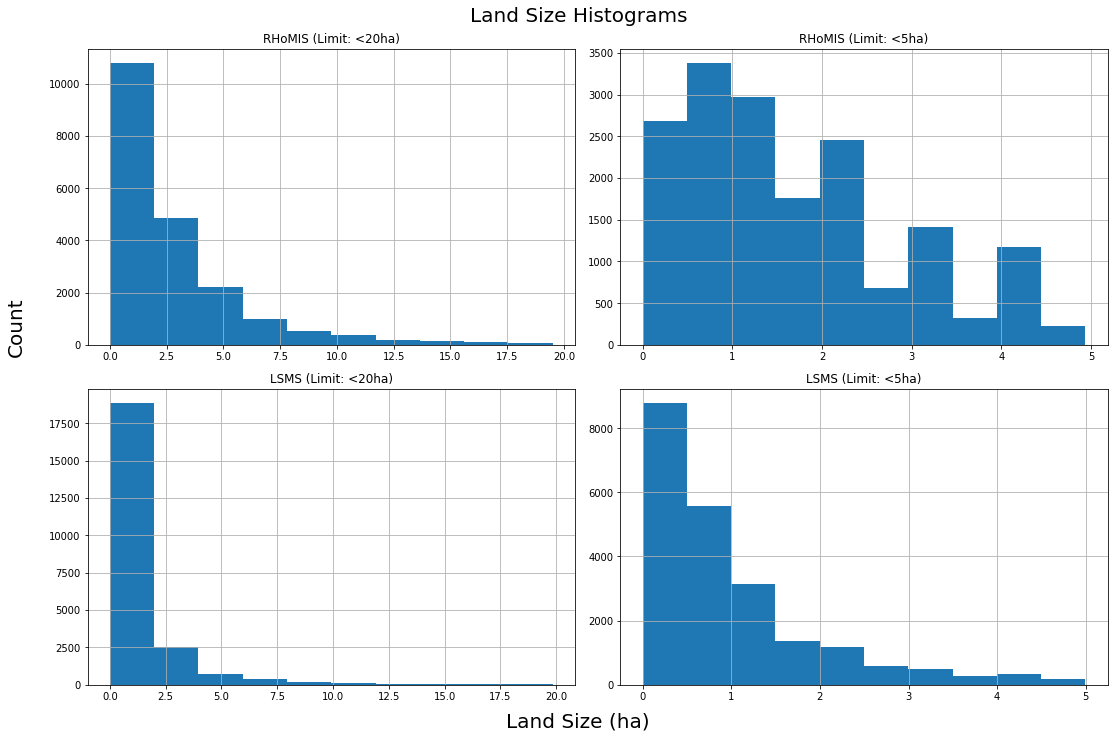

In [14]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

fig.suptitle("Land Size Histograms", fontsize=20)


fig.text(0.5,-0.02, "Land Size (ha)", ha="center", fontsize=20)
fig.text(-0.02,0.5, "Count", ha="center", rotation="vertical", fontsize=20)

ax[0][0].title.set_text("RHoMIS (Limit: <20ha)")
ax[0][1].title.set_text("RHoMIS (Limit: <5ha)")

ax[1][0].title.set_text("LSMS (Limit: <20ha)")
ax[1][1].title.set_text("LSMS (Limit: <5ha)")

geo_indicator.loc[geo_indicator["LandCultivated"]<20,"LandCultivated"].hist(ax=ax[0][0])
geo_indicator.loc[geo_indicator["LandCultivated"]<5,"LandCultivated"].hist(ax=ax[0][1])

lsms_data.loc[lsms_data["Farm size [ha]"]<20,"Farm size [ha]"].hist(ax=ax[1][0])
lsms_data.loc[lsms_data["Farm size [ha]"]<5,"Farm size [ha]"].hist(ax=ax[1][1])
fig.tight_layout()
fig.savefig("./outputs/exploratory/land_size/land_size_dist.png")

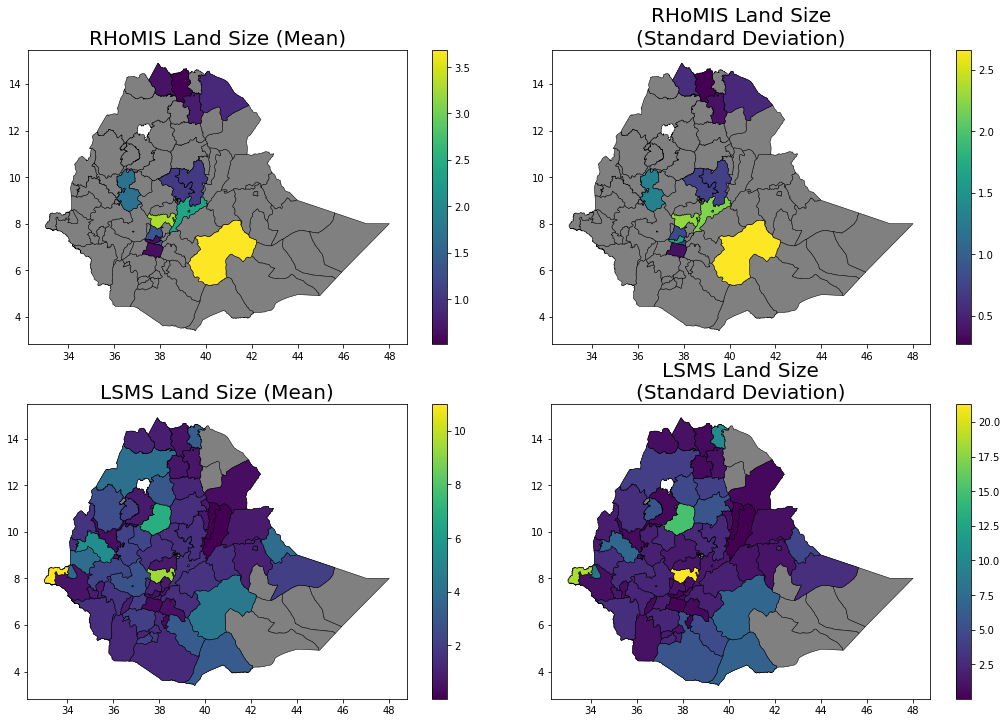

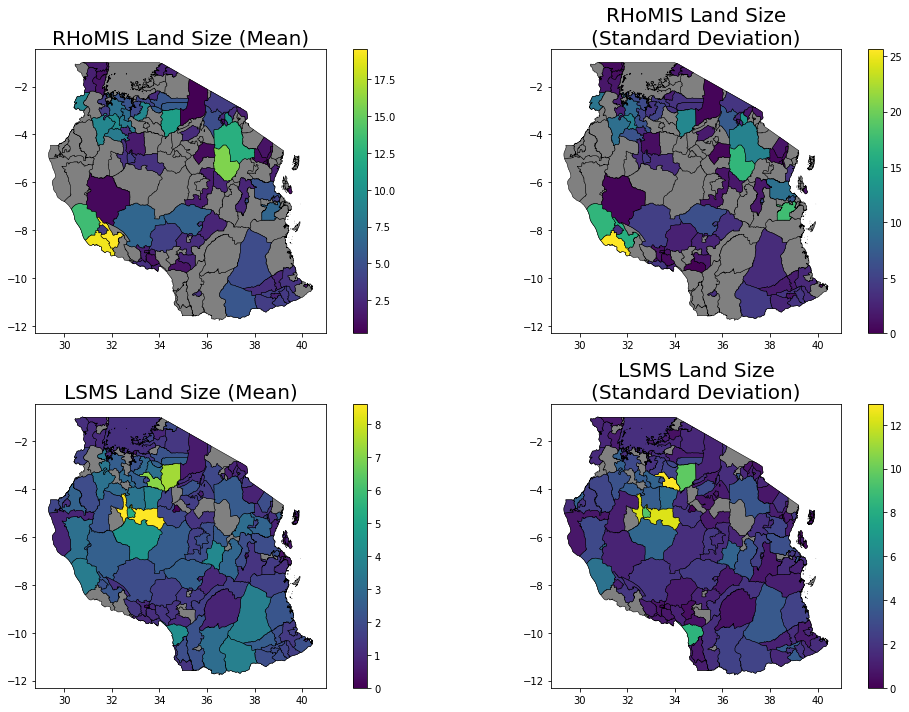

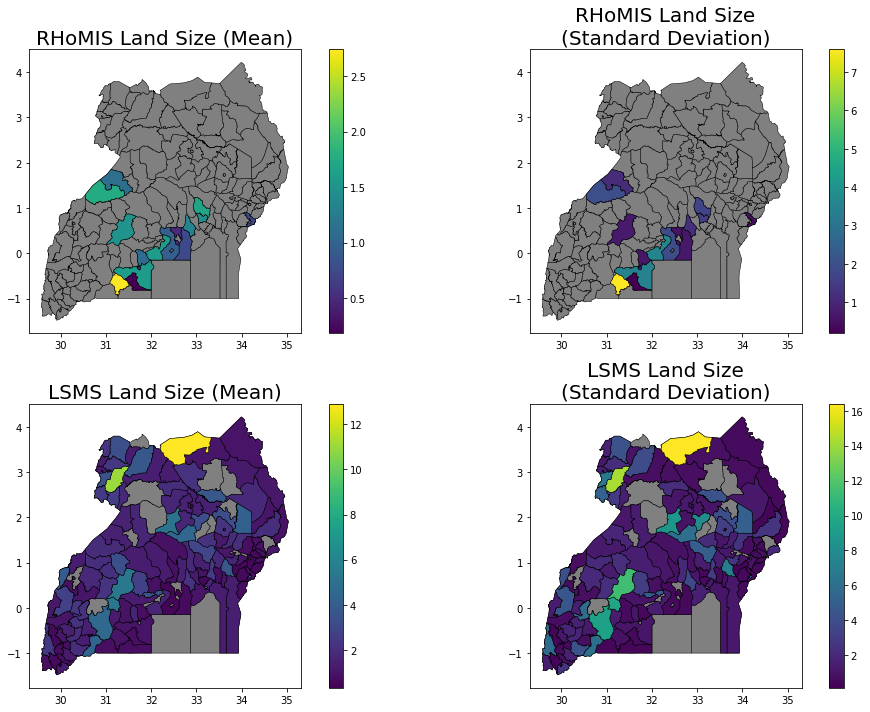

In [15]:
countries = ["ETH", "TZA", "UGA"]

for country in countries:

    rhomis_mean_land_per_geoid=geo_indicator.loc[(geo_indicator["iso_3"]==country) & (geo_indicator["LandCultivated"]<100),["GEO2LABEL","LandCultivated"]].groupby("GEO2LABEL", as_index=False).mean("LandCultivated")
    rhomis_sd_land_per_geoid=geo_indicator.loc[(geo_indicator["iso_3"]==country) & (geo_indicator["LandCultivated"]<100),["GEO2LABEL","LandCultivated"]].groupby("GEO2LABEL", as_index=False).agg(np.std)

    lsms_mean_land_per_geoid=lsms_data.loc[(lsms_data["iso_3"]==country) & (lsms_data["Farm size [ha]"]<100),["GEO2LABEL","Farm size [ha]"]].groupby("GEO2LABEL", as_index=False).mean("Farm size [ha]")
    lsms_sd_land_per_geoid=lsms_data.loc[(lsms_data["iso_3"]==country) & (lsms_data["Farm size [ha]"]<100),["GEO2LABEL","Farm size [ha]"]].groupby("GEO2LABEL", as_index=False).agg(np.std)

    rhomis_mean_land_per_geoid.dropna(inplace=True)
    rhomis_sd_land_per_geoid.dropna(inplace=True)

    lsms_mean_land_per_geoid.dropna(inplace=True)
    lsms_mean_land_per_geoid.rename(columns={"Farm size [ha]":"LandCultivated"},inplace=True)
    lsms_sd_land_per_geoid.dropna(inplace=True)
    lsms_sd_land_per_geoid.rename(columns={"Farm size [ha]":"LandCultivated"},inplace=True)
   
    rhomis_land_stats_per_geoid= rhomis_mean_land_per_geoid.merge(rhomis_sd_land_per_geoid, on="GEO2LABEL", suffixes=("_mean","_sd"))
    rhomis_subset=rhomis_land_stats_per_geoid.merge(ipums_terra.loc[ipums_terra["iso_3"]==country,:], how="inner", on="GEO2LABEL")
    rhomis_subset=gpd.GeoDataFrame(rhomis_subset)

    lsms_land_stats_per_geoid= lsms_mean_land_per_geoid.merge(lsms_sd_land_per_geoid, on="GEO2LABEL", suffixes=("_mean","_sd"))
    lsms_subset=lsms_land_stats_per_geoid.merge(ipums_terra.loc[ipums_terra["iso_3"]==country,:], how="inner", on="GEO2LABEL")
    lsms_subset=gpd.GeoDataFrame(lsms_subset)


    fig, ax = plt.subplots(2,2, figsize=(15,10))

    ax[0][0].set_title("RHoMIS Land Size (Mean)", fontsize=20)
    ax[0][1].set_title("RHoMIS Land Size\n(Standard Deviation)", fontsize=20)

    ax[1][0].set_title("LSMS Land Size (Mean)", fontsize=20)
    ax[1][1].set_title("LSMS Land Size\n(Standard Deviation)", fontsize=20)

    ipums_terra.loc[ipums_terra["iso_3"]==country,:].plot(ax=ax[0][0], color="grey", edgecolor="black",linewidth=0.5)
    rhomis_subset.plot(ax=ax[0][0],column="LandCultivated_mean", legend=True, edgecolor="black",linewidth=0.5)

    ipums_terra.loc[ipums_terra["iso_3"]==country,:].plot(ax=ax[0][1], color="grey",edgecolor="black",linewidth=0.5)
    rhomis_subset.plot(ax=ax[0][1],column="LandCultivated_sd", legend=True,edgecolor="black",linewidth=0.5)

    ipums_terra.loc[ipums_terra["iso_3"]==country,:].plot(ax=ax[1][0], color="grey", edgecolor="black",linewidth=0.5)
    lsms_subset.plot(ax=ax[1][0],column="LandCultivated_mean", legend=True, edgecolor="black",linewidth=0.5)

    ipums_terra.loc[ipums_terra["iso_3"]==country,:].plot(ax=ax[1][1], color="grey",edgecolor="black",linewidth=0.5)
    lsms_subset.plot(ax=ax[1][1],column="LandCultivated_sd", legend=True,edgecolor="black",linewidth=0.5)
    fig.tight_layout()
    fig.savefig("outputs/exploratory/land_size/"+country+"_map.png")

In [24]:
land_cultilsms_subset.corr()[]

,LandCultivated_mean,LandCultivated_sd,GEOID,GEO2,EDUCTERTIARY_GEO2A,EDUCSECOND_GEO2A,EDUCPRIMARY_GEO2A,EDUCLESSPRIM_GEO2A,SCHOOL0617_GEO2A,SCHOOL1015_GEO2A,...,IGBP_WDYSVNNS_percent_area_bin_GEO2IGBP_2012_2012,IGBP_SAVANNAS_percent_area_bin_GEO2IGBP_2012_2012,IGBP_CROPLAND_percent_area_bin_GEO2IGBP_2012_2012,IGBP_MXDFRST_percent_area_bin_GEO2IGBP_2012_2012,IGBP_BARREN_percent_area_bin_GEO2IGBP_2012_2012,IGBP_WATER_percent_area_bin_GEO2IGBP_2012_2012,IGBP_URBAN_percent_area_bin_GEO2IGBP_2012_2012,IGBP_num_classes_GEO2IGBP_2012_2012,IGBP_mode_GEO2IGBP_2012_2012,year
LandCultivated_mean,1.000000,0.928249,0.070687,0.070687,-0.125474,-0.143566,-0.153825,0.153825,0.040164,0.068436,...,0.151598,0.326003,-0.136050,-0.183137,-0.100427,-0.096958,-0.151567,0.001040,-0.054739,NaN
LandCultivated_sd,0.928249,1.000000,0.043112,0.043112,-0.111739,-0.130689,-0.133980,0.133980,0.076950,0.103313,...,0.065538,0.209028,-0.136336,-0.170274,-0.007336,-0.148448,-0.150633,-0.004640,0.023231,NaN
GEOID,0.070687,0.043112,1.000000,1.000000,-0.064585,0.028059,-0.264162,0.264162,-0.174094,-0.142028,...,0.075243,0.086184,0.026383,-0.051064,-0.235393,-0.061135,-0.082169,-0.182199,-0.093881,NaN
GEO2,0.070687,0.043112,1.000000,1.000000,-0.064585,0.028059,-0.264162,0.264162,-0.174094,-0.142028,...,0.075243,0.086184,0.026383,-0.051064,-0.235393,-0.061135,-0.082169,-0.182199,-0.093881,NaN
EDUCTERTIARY_GEO2A,-0.125474,-0.111739,-0.064585,-0.064585,1.000000,0.930047,0.741390,-0.741390,0.137261,0.099895,...,-0.179826,-0.135244,0.213393,-0.031611,0.276375,-0.023351,0.882927,-0.249674,0.065571,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IGBP_WATER_percent_area_bin_GEO2IGBP_2012_2012,-0.096958,-0.148448,-0.061135,-0.061135,-0.023351,-0.067291,0.095900,-0.095900,-0.100853,-0.070254,...,-0.207285,-0.190416,-0.299622,-0.084079,0.087825,1.000000,-0.155858,0.525038,-0.614256,NaN
IGBP_URBAN_percent_area_bin_GEO2IGBP_2012_2012,-0.151567,-0.150633,-0.082169,-0.082169,0.882927,0.753416,0.683290,-0.683290,0.062144,-0.056731,...,-0.140434,-0.066041,0.404925,-0.078809,0.577438,-0.155858,1.000000,-0.309129,0.040619,NaN
IGBP_num_classes_GEO2IGBP_2012_2012,0.001040,-0.004640,-0.182199,-0.182199,-0.249674,-0.342279,-0.185140,0.185140,-0.036377,-0.045349,...,-0.103251,-0.099446,-0.191621,0.167076,0.023123,0.525038,-0.309129,1.000000,-0.242407,NaN
IGBP_mode_GEO2IGBP_2012_2012,-0.054739,0.023231,-0.093881,-0.093881,0.065571,0.078938,0.115773,-0.115773,0.162087,0.147074,...,-0.222423,-0.252398,0.057589,-0.109193,-0.111159,-0.614256,0.040619,-0.242407,1.000000,NaN


In [160]:
land_cult_mean = geo_indicator.loc[:,["iso_3","GEO2LABEL", "LandCultivated"]].groupby(["GEO2LABEL","iso_3"],as_index=False).mean()
land_cult_mean.rename(columns={"LandCultivated":"LandCultivated_mean"}, inplace=True)
land_cult_std = geo_indicator.loc[:,["iso_3","GEO2LABEL", "LandCultivated"]].groupby(["GEO2LABEL", "iso_3"],as_index=False).std()
land_cult_std.rename(columns={"LandCultivated":"LandCultivated_std"}, inplace=True)

land_cult_med = geo_indicator.loc[:,["iso_3","GEO2LABEL", "LandCultivated"]].groupby(["GEO2LABEL", "iso_3"],as_index=False).median()
land_cult_med.rename(columns={"LandCultivated":"LandCultivated_median"}, inplace=True)

land_cult_skew = pd.DataFrame(geo_indicator.loc[:,["iso_3","GEO2LABEL", "LandCultivated"]]).groupby(["GEO2LABEL", "iso_3"],as_index=False).skew()
land_cult_skew.rename(columns={"LandCultivated":"LandCultivated_skew"}, inplace=True)

land_cult_status = land_cult_mean.merge(land_cult_med).merge(land_cult_skew).merge(land_cult_std)

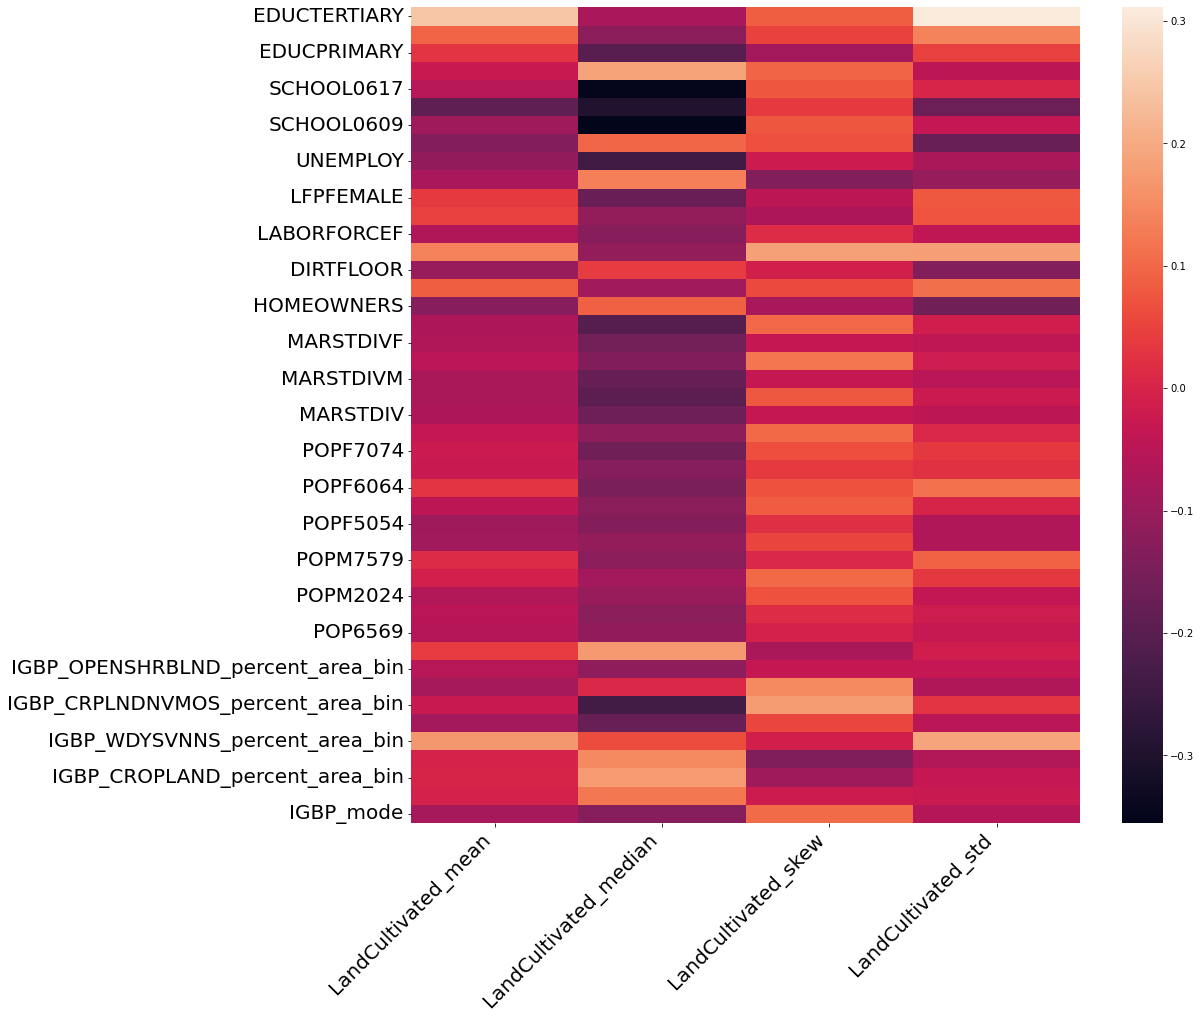

In [175]:
land_cult_status_merged = land_cult_status.merge(ipums_terra, how="inner", left_on=["iso_3","GEO2LABEL"], right_on=["iso_3","GEO2LABEL"])
correlations = land_cult_status_merged.corr().loc[:,["LandCultivated_mean", "LandCultivated_median","LandCultivated_skew", "LandCultivated_std"]]
correlations.index = correlations.index.str.replace("_GEO2IGBP_2012_2012","")
correlations.index = correlations.index.str.replace("_GEO2A","")



numeric_subsets = pd.DataFrame({
    "more_than_0.1":(correlations>0.1).any(axis=1),
    "less_than_minus_0.1":(correlations<-0.1).any(axis=1)
    }).any(axis=1)

row_name_inclusions= ~correlations.index.isin(["LandCultivated_mean", "LandCultivated_median", "LandCultivated_skew","LandCultivated_std", "year"]) 

subset_df = pd.DataFrame({
    "numberic_subsets":numeric_subsets,
    "row_name_inclusions":row_name_inclusions
})

subset_all = subset_df.all(axis=1)

fig, ax = plt.subplots(figsize=(15,15))
plt.yticks(fontsize=20)
sns.heatmap(correlations.loc[subset_all,:], ax=ax)
plt.xticks(fontsize=20, rotation=45, ha="right")
fig.savefig("./outputs/exploratory/distribution_correlations/rhomis_correlations.png")
fig.show()


,more_than_0.1,less_than_minus_0.1
LandCultivated_mean,True,False
LandCultivated_median,True,True
LandCultivated_skew,True,True
LandCultivated_std,True,False
GEOID,False,False
...,...,...
IGBP_WATER_percent_area_bin,False,False
IGBP_URBAN_percent_area_bin,False,False
IGBP_num_classes,False,False
IGBP_mode,True,True


,LandCultivated_mean,LandCultivated_median,LandCultivated_skew,LandCultivated_std
LandCultivated_mean,1.000000,0.149513,0.225052,0.905326
LandCultivated_median,0.149513,1.000000,-0.169643,-0.040066
LandCultivated_skew,0.225052,-0.169643,1.000000,0.287218
LandCultivated_std,0.905326,-0.040066,0.287218,1.000000
GEOID,-0.030984,-0.053493,-0.043711,-0.011620
...,...,...,...,...
IGBP_WATER_percent_area_bin,-0.066069,-0.051990,-0.014210,-0.049868
IGBP_URBAN_percent_area_bin,-0.051853,-0.049994,-0.042463,-0.034281
IGBP_num_classes,0.092783,-0.068583,0.086607,0.081912
IGBP_mode,-0.080466,-0.129848,0.104169,-0.057491


In [154]:
lsms_land_cult_mean = lsms_data.loc[:,["iso_3","GEO2LABEL", "Farm size [ha]"]].groupby(["GEO2LABEL","iso_3"],as_index=False).mean()
lsms_land_cult_mean.rename(columns={"Farm size [ha]":"Farm size [ha] (mean)"}, inplace=True)
lsms_land_cult_std = lsms_data.loc[:,["iso_3","GEO2LABEL", "Farm size [ha]"]].groupby(["GEO2LABEL", "iso_3"],as_index=False).std()
lsms_land_cult_std.rename(columns={"Farm size [ha]":"Farm size [ha] (std)"}, inplace=True)

lsms_land_cult_med = lsms_data.loc[:,["iso_3","GEO2LABEL", "Farm size [ha]"]].groupby(["GEO2LABEL", "iso_3"],as_index=False).median()
lsms_land_cult_med.rename(columns={"Farm size [ha]":"Farm size [ha] (med)"}, inplace=True)

lsms_land_cult_skew = pd.DataFrame(lsms_data.loc[:,["iso_3","GEO2LABEL", "Farm size [ha]"]]).groupby(["GEO2LABEL", "iso_3"],as_index=False).skew()
lsms_land_cult_skew.rename(columns={"Farm size [ha]":"Farm size [ha] (skew)"}, inplace=True)

lsms_land_cult_status = lsms_land_cult_mean.merge(lsms_land_cult_med).merge(lsms_land_cult_skew).merge(lsms_land_cult_std)

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

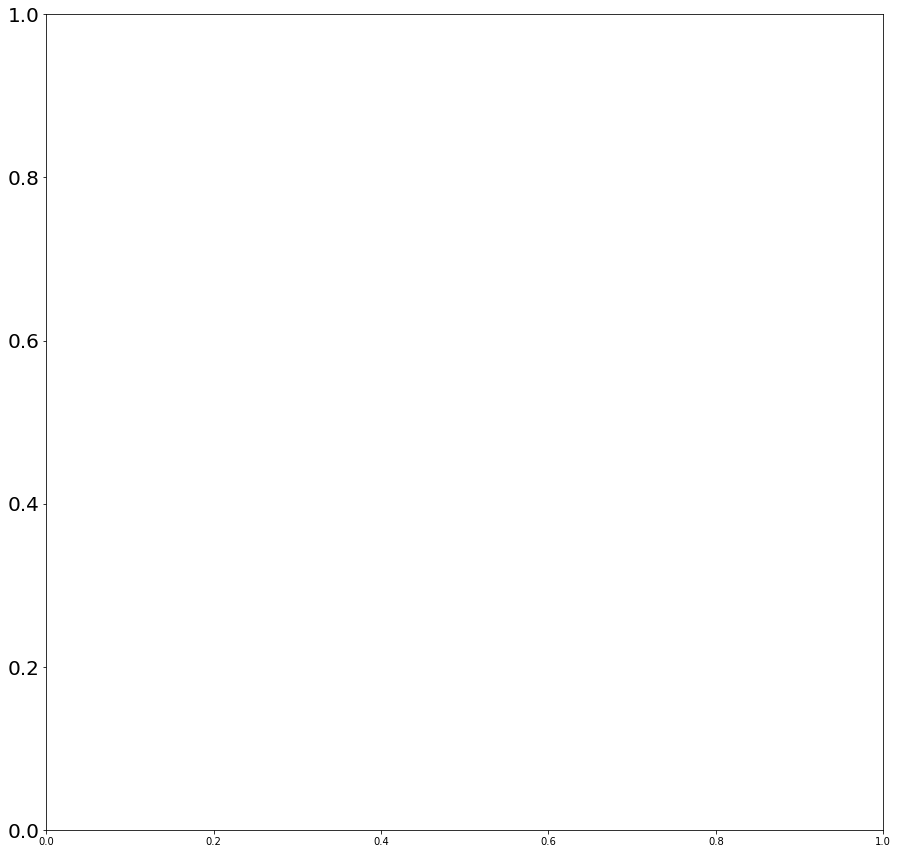

In [176]:
lsms_land_cult_status_merged = lsms_land_cult_status.merge(ipums_terra, how="inner", left_on=["iso_3","GEO2LABEL"], right_on=["iso_3","GEO2LABEL"])
lsms_correlations = lsms_land_cult_status_merged.corr().loc[:,["Farm size [ha] (mean)", "Farm size [ha] (med)", "Farm size [ha] (skew)","Farm size [ha] (std)"]]
lsms_correlations.index = lsms_correlations.index.str.replace("_GEO2IGBP_2012_2012","")
lsms_correlations.index = lsms_correlations.index.str.replace("_GEO2A","")

# subset1 = ~lsms_correlations.index.isin(["Farm size [ha] (mean)", "Farm size [ha] (med)","Farm size [ha] (skew)", "Farm size [ha] (std)"]) 
# subset2 = (lsms_correlations>0.1).any(axis=1)
# subset_all = pd.DataFrame({"subset1":subset1,"subset2":subset2}).all(axis=1)

numeric_subsets = pd.DataFrame({
    "more_than_0.1":(lsms_correlations>0.1).any(axis=1),
    "less_than_minus_0.1":(lsms_correlations<-0.1).any(axis=1)
    }).any(axis=1)

row_name_inclusions= ~lsms_correlations.index.isin(["Farm size [ha] (mean)", "Farm size [ha] (med)","Farm size [ha] (skew)", "Farm size [ha] (std)"]) 

subset_df = pd.DataFrame({
    "numberic_subsets":numeric_subsets,
    "row_name_inclusions":row_name_inclusions
})

subset_all = subset_df.all(axis=1)




fig, ax = plt.subplots(figsize=(15,15))
plt.yticks(fontsize=20)
sns.heatmap(lsms_correlations.loc[subset_all,:], ax=ax)
plt.xticks(fontsize=20, rotation=45, ha="right")
fig.savefig("./outputs/exploratory/distribution_correlations/lsms_correlations.png")
fig.show()


In [103]:
lsms_land_cult_status.col

,GEO2LABEL,iso_3,Farm size [ha] (mean),Farm size [ha] (med),Farm size [ha] (std)
0,Aba South,NGA,0.017335,0.017335,NaN
1,Abak,NGA,0.270877,0.232250,0.221878
2,Abakaliki,NGA,0.513026,0.444043,0.343628
3,Aboh Mbaise,NGA,0.108258,0.096102,0.034889
4,Abua Odua,NGA,0.702464,0.175286,1.443396
...,...,...,...,...,...
697,Ziro,BFA,4.632222,3.750000,4.291775
698,Zondoma,BFA,4.548485,4.000000,2.873697
699,Zone 1,ETH,0.386225,0.192823,0.439752
700,Zone 3,ETH,0.025713,0.000000,0.050192


# Clustering Households Spatially

In [21]:
cluster_labels = db_scan.cluster_gps_points(indicator_data, "GPS_LON", "GPS_LAT", epsilon=0.1)

# Exploring LSMS Data

# Reading in LSMS prepped Data
Reading information from LSMS. All countries include GPS coordinates, except for Mali and Burkina Faso. In the case of Burkina, all of the districts were available in IPUMS terra, and related to subnational level 2. In the case of Mali, all of the districts were present, except for 443 households that were labelled as "commune", this was likely done in error. 

Seeing as there are so few RHoMIS points in Mali anyway, Mali LSMS was excluded.

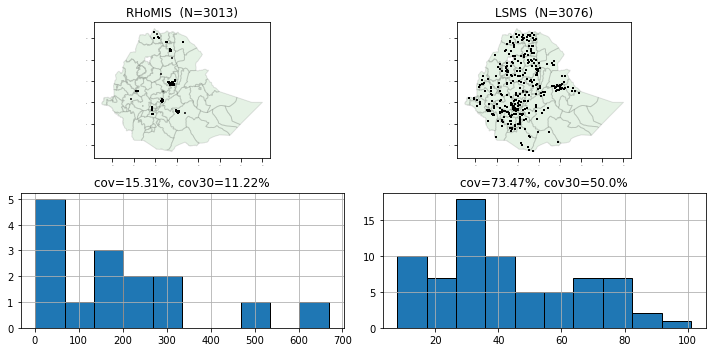

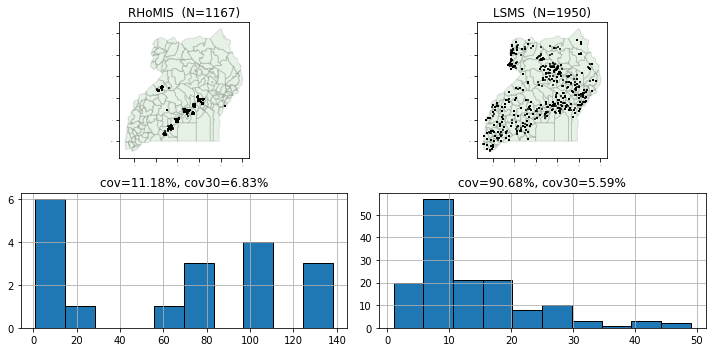

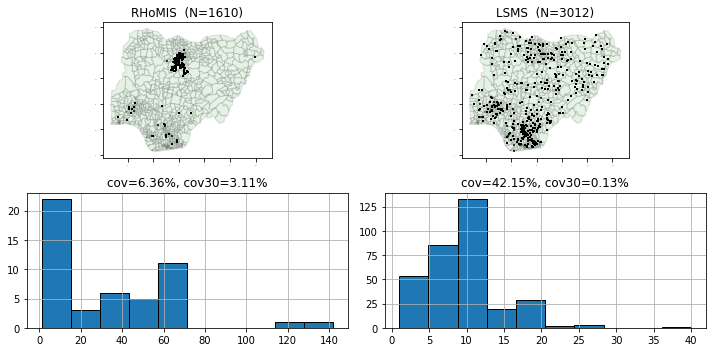

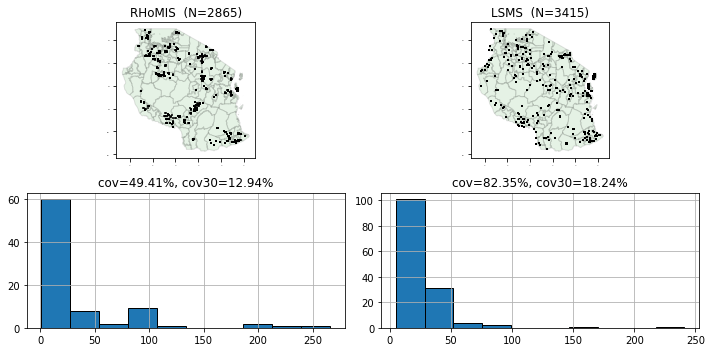

In [22]:
countries=geo_indicator.loc[geo_indicator["iso_3"].notna(),"iso_3"].unique()
# Counts per subnational unit
counts_per_subnational_unit = geo_indicator.groupby(["iso_3", "GEOID"]).size().reset_index(name="counts")
counts_per_subnational_unit_lsms = lsms_data.groupby(["iso_3", "GEOID"]).size().reset_index(name="counts")

counts_per_subnational_unit.to_csv("./outputs/exploratory/hhs_per_unit.csv")

for country in countries:
    
    number_rhomis_subnational_region = len(geo_indicator.loc[geo_indicator["iso_3"]==country,"GEOID"].unique())
    number_total_subnational_region = len(ipums_terra.loc[ipums_terra["iso_3"]==country,"GEOID"].unique())

    number_lsms_subnational_region = len(lsms_data.loc[lsms_data["iso_3"]==country,"GEOID"].unique())

    counts_30_rhomis = geo_indicator.loc[geo_indicator["iso_3"]==country,"GEOID"].value_counts()
    counts_30_rhomis = counts_30_rhomis[counts_30_rhomis>30].count() 
    cov30_rhomis = str(round(100*counts_30_rhomis/number_total_subnational_region,2))+"%"

    coverage_rhomis = str(round(100*number_rhomis_subnational_region/number_total_subnational_region,2))+"%"
    Nrhomis=str(geo_indicator.loc[geo_indicator["iso_3"]==country,:].shape[0])


    counts_30_lsms = lsms_data.loc[lsms_data["iso_3"]==country,"GEOID"].value_counts()
    counts_30_lsms = counts_30_lsms[counts_30_lsms>30].count() 
    cov30_lsms = str(round(100*counts_30_lsms/number_total_subnational_region,2))+"%"

    coverage_lsms = str(round(100*number_lsms_subnational_region/number_total_subnational_region,2))+"%"
    Nlsms=str(lsms_data.loc[lsms_data["iso_3"]==country,:].shape[0])

    

    if country not in ["BFA", "GHA", "KEN", "RWA","MLI"]:
    
        fig, ax = plt.subplots(2,2,figsize=(10,5))
        # ax[0].set_title("cov="+coverage_rhomis+", cov30="+cov30_rhomis+", N_rhomis="+Nrhomis, fontsize=25)
        # ax[0].tick_params(labelsize=20)
        plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
        ax[0][0].tick_params(labelsize=0)
        ax[0][1].tick_params(labelsize=0)
        # plt.suptitle(country, fontsize=20)


        ax[0][0].title.set_text('RHoMIS '+' (N=' + Nrhomis+")")# seems to work too.
        ax[0][1].title.set_text('LSMS '+' (N=' + Nlsms+")")# seems to work too.

        ax[1][0].set_title("cov="+coverage_rhomis+", cov30="+cov30_rhomis)
        ax[1][1].set_title("cov="+coverage_lsms+", cov30="+cov30_lsms)



        counts_per_subnational_unit.loc[counts_per_subnational_unit["iso_3"]==country,"counts"].hist(ax=ax[1][0], edgecolor="black")
        counts_per_subnational_unit_lsms.loc[counts_per_subnational_unit_lsms["iso_3"]==country,"counts"].hist(ax=ax[1][1], edgecolor="black")

        
        ipums_terra.loc[ipums_terra["iso_3"]==country,:].plot(ax=ax[0][0], color="green", edgecolor="black", alpha=0.1)
        geo_indicator.loc[geo_indicator["iso_3"]==country,:].plot(ax=ax[0][0], marker=0, color='black', markersize=5)

        ipums_terra.loc[ipums_terra["iso_3"]==country,:].plot(ax=ax[0][1], color="green", edgecolor="black", alpha=0.1)
        lsms_data.loc[lsms_data["iso_3"]==country,:].plot(ax=ax[0][1], marker=0, color="black", markersize=5)
        fig.tight_layout()
        fig.savefig('./outputs/exploratory/map_per_country/'+country+'.png')

# Plotting sample Maps to Illustrate Data Types

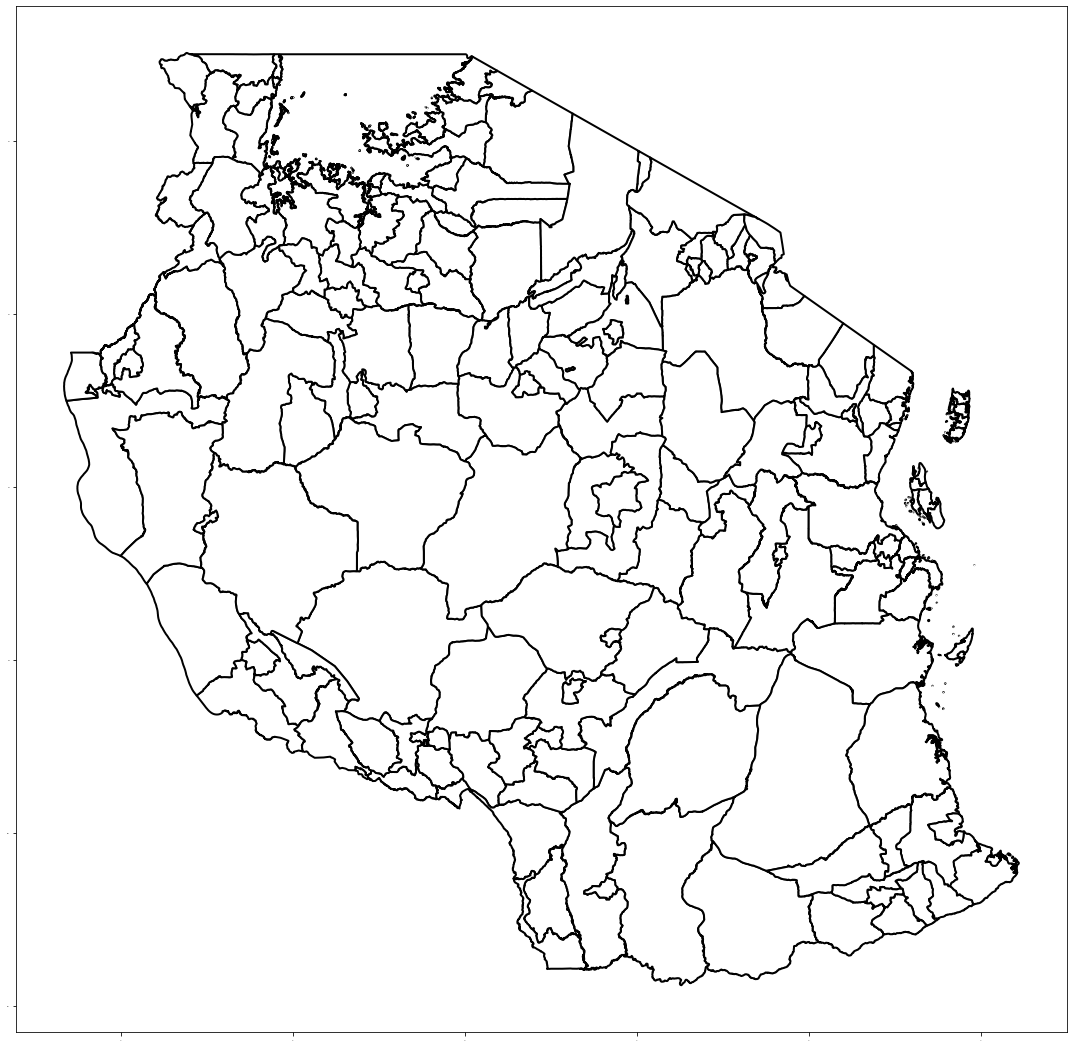

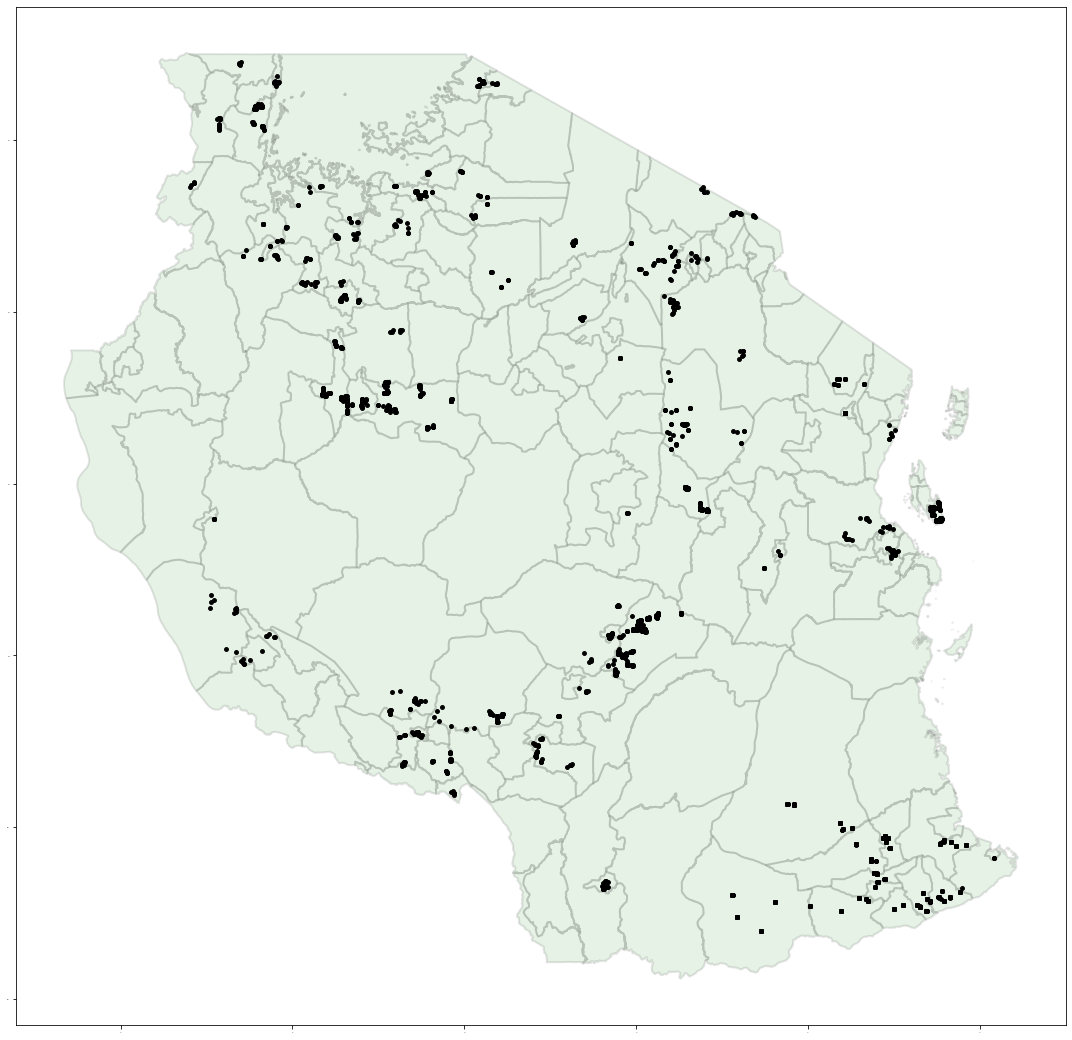

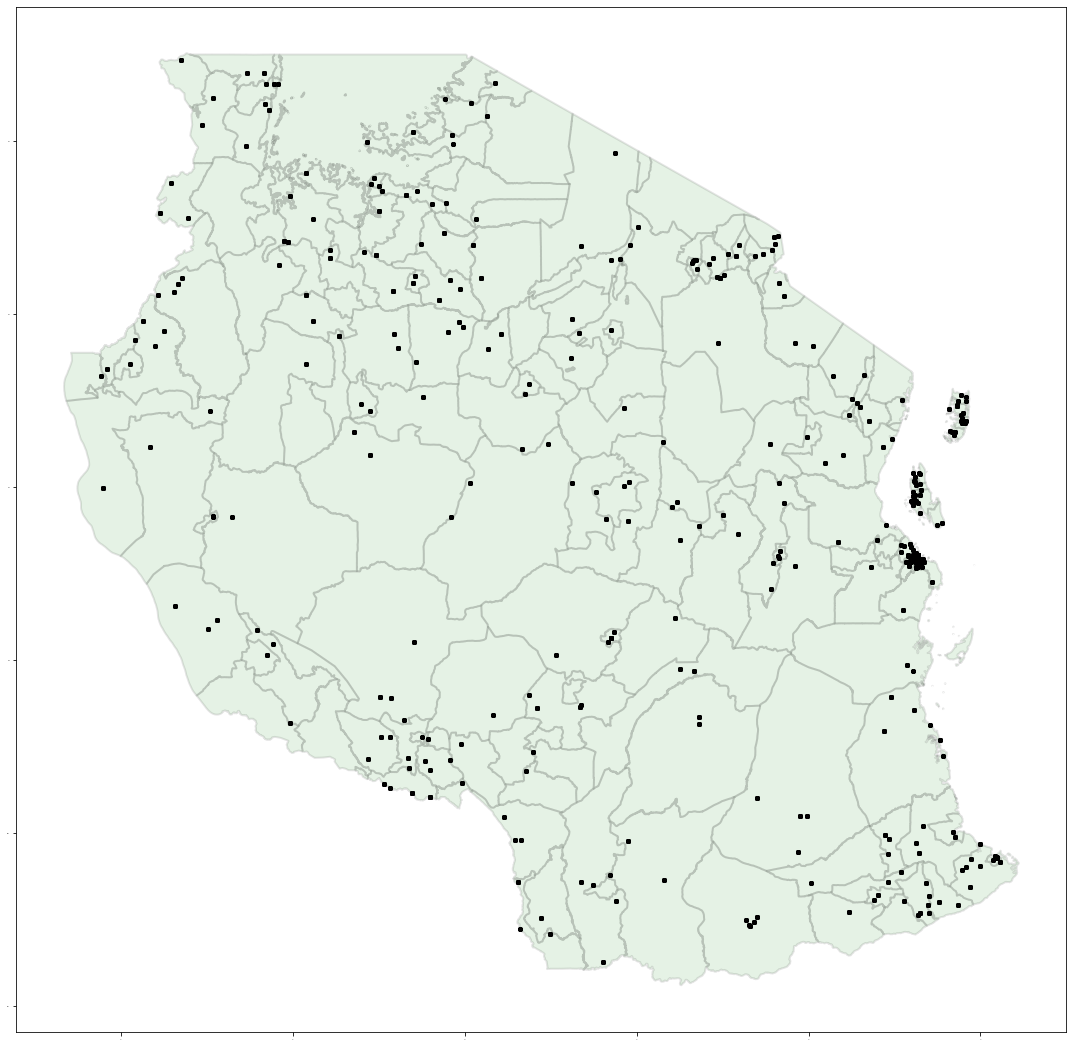

In [23]:
country="TZA"
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.tick_params(labelsize=0)

# Plain Map
ipums_terra.loc[ipums_terra["iso_3"]==country,:].plot(ax=ax, color="white", edgecolor="black",  linewidth=2)
fig.tight_layout()
fig.savefig("./outputs/samples/map.png")

# Map with RHoMIS
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.tick_params(labelsize=0)

ipums_terra.loc[ipums_terra["iso_3"]==country,:].plot(ax=ax, color="green", edgecolor="black", alpha=0.1, linewidth=2)
geo_indicator.loc[geo_indicator["iso_3"]==country,:].plot(ax=ax, marker='o', color='black', markersize=15)
fig.tight_layout()
fig.savefig("./outputs/samples/map_with_rhomis.png")

# Map with LSMS
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.tick_params(labelsize=0)

ipums_terra.loc[ipums_terra["iso_3"]==country,:].plot(ax=ax, color="green", edgecolor="black", alpha=0.1, linewidth=2)
lsms_data.loc[lsms_data["iso_3"]==country,:].plot(ax=ax, marker='o', color="black", markersize=15)
fig.tight_layout()
fig.savefig("./outputs/samples/map_with_lsms.png")